# Initial setup
- Library imports
- Utility functions
- Formatting JSON input

In [1]:
import pandas as pd
import numpy as np
import json
import os
import wget
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

In [2]:
with open(f"items/items.json", "r") as fp:
    item_dict = json.load(fp)
    ITEMS = {i: item_dict[i]["name"] for i in item_dict.keys()}
    ITEM_ICONS = {i: item_dict[i]["icon"] for i in item_dict.keys()}

with open(f"champions.json", "r", encoding="utf-8") as fp:
    CHAMP_DICT = json.load(fp)
    CHAMP_NAME_TO_ID = {c: CHAMP_DICT[c]["id"] for c in CHAMP_DICT.keys()}
    CHAMP_ID_TO_NAME = {CHAMP_DICT[c]["id"]: c for c in CHAMP_DICT.keys()}
    CHAMPION_ICONS = {c: CHAMP_DICT[c]["icon"] for c in CHAMP_DICT.keys()}

def get_item_name(item_id: int):
    return ITEMS.get(str(int(item_id)), "")

def get_item_icon(item_id: int):
    if not item_id:
        return None
    url = ITEM_ICONS.get(str(int(item_id)))
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

def get_champion_id(champion_name: str):
    if champion_name is None:
        return None
    return CHAMP_NAME_TO_ID.get(champion_name, "")

def get_champion_name(champion_id: int):
    return CHAMP_ID_TO_NAME.get(champion_id)

def get_champion_icon(champion_name: int):
    if not champion_name:
        return None
    url = CHAMPION_ICONS.get(champion_name)
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    except:
        return Image.new("RGB", (64, 64))

In [3]:
feature_dir = os.path.join("features", "postgame")
filenames = os.listdir(feature_dir)

df_list = []
for fn in filenames:
    sub_df = pd.read_json(os.path.join(feature_dir, fn))
    df_list.append(sub_df)

df = pd.concat(df_list)

print(f"Found {len(df)} matches")

Found 25150 matches


In [4]:
df_expanded = pd.concat([
    df[col].apply(pd.Series).add_prefix(f'{col}_')
    for col in df.columns
], axis=1)

for i in range(10):
    items_col = f"{i}_items"
    items_expanded = df_expanded[items_col].apply(pd.Series)
    items_expanded.columns = [f"{items_col}_{j}" for j in range(items_expanded.shape[1])]
    df_expanded = pd.concat([df_expanded, items_expanded], axis=1)
    df_expanded.drop(f"{i}_items", axis=1, inplace=True)

In [5]:
LANES = ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]
print(f"Total matches: {len(df_expanded)}")
df_same_lane = df_expanded[
    (df_expanded["0_lane"] == "TOP")     & (df_expanded["1_lane"] == "TOP") &
    (df_expanded["2_lane"] == "JUNGLE")  & (df_expanded["3_lane"] == "JUNGLE") &
    (df_expanded["4_lane"] == "MIDDLE")  & (df_expanded["5_lane"] == "MIDDLE") &
    (df_expanded["6_lane"] == "BOTTOM")  & (df_expanded["7_lane"] == "BOTTOM") & 
    (df_expanded["8_lane"] == "UTILITY") & (df_expanded["9_lane"] == "UTILITY")
]
print(f"Number of matches with correct lane setup: {len(df_same_lane)}")
df_same_lane.to_csv("features/features_expanded.csv", index=False)

Total matches: 25150
Number of matches with correct lane setup: 24381


In [6]:
# Load champion IDs
with open(f"champions.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    info = {json_data[champion]["id"]: champion for champion in json_data.keys()}

# Load Item IDs (Only legendary items)
with open(f"items/items.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)
    item_ids = [json_data[str_id]["id"] for str_id in json_data.keys() if json_data[str_id]["tier"] in [3, 4]]
    item_ids = set(item_ids)

In [7]:
OHE_PLAYER_COLS = [f"player_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ALLY_COLS = [f"ally_{c}" for c in CHAMP_NAME_TO_ID.keys()]
OHE_ENEMY_COLS = [f"enemy_{c}" for c in CHAMP_NAME_TO_ID.keys()]

# Creating examples
Creating 10 examples out of each match.

In [8]:
# Takes some time to process
def get_team_champions_and_gold(row):
    info = {
        "champions": {
            team: []
            for team in [100, 200]
        },
        "gold": {
            team: 0
            for team in [100, 200]
        },
    }
    for id in range(10):
        info["champions"][row[f"{id}_teamId"]].append(get_champion_name(row[f"{id}_championId"]))
        info["gold"][row[f"{id}_teamId"]] += row[f"{id}_goldEarned"]
    return info["champions"], info["gold"]

def build_new_row(row, cols, playerId, allies, enemies, gold):
    new_row = {}
    player_champion = get_champion_name(row[f"{playerId}_championId"])

    # Player info
    for c in cols:
        new_row[c] = row[f"{playerId}_{c}"]

    # OHE for lane
    new_row[row[f"{playerId}_lane"]] = 1

    new_row[f"player_{player_champion}"] = 1

    # OHE for allies and enemies
    for champ in allies:
        if champ != player_champion:
            new_row[f"ally_{champ}"] = 1
    for champ in enemies:
        new_row[f"enemy_{champ}"] = 1

    new_row["teamGold"] = gold

    return new_row

def expand_match(row):
    team_champions, team_gold = get_team_champions_and_gold(row)
    cols = ["championId", "kills", "deaths", "assists", "goldEarned"] + [f"items_{i}" for i in range(6)]
    new_rows = []

    for playerId in range(10):
        team = row[f"{playerId}_teamId"]
        allies = team_champions[team]
        gold = team_gold[team]
        enemies = team_champions[100 if team == 200 else 200]

        row_data = build_new_row(row, cols, playerId, allies, enemies, gold)
        new_rows.append(row_data)

    return pd.DataFrame(new_rows)

expanded_list = df_same_lane.apply(expand_match, axis=1).tolist()
input_df = pd.concat(expanded_list, ignore_index=True, axis=0).fillna(0)

In [9]:
new_cols = pd.DataFrame({
    "KDA": (input_df["kills"] + input_df["assists"]) / input_df["deaths"],
    "relativeGold": input_df["goldEarned"] / input_df["teamGold"]
})

input_df = pd.concat([input_df, new_cols], axis=1)

## Filtering for high-performance matches

In [10]:
# Amount of games with good performance
for lane in LANES:
    total_matches = len(input_df[(input_df[lane] == 1)])
    print(f"Lane: {lane} -- total matches: {total_matches}")
    lane_df = pd.DataFrame(dtype=str)
    for kda in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        for relativeGold in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
            ratio = len(
                input_df[(input_df[lane] == 1) & \
                         (input_df["KDA"] >= kda) & \
                         (input_df["relativeGold"] >= relativeGold)
                        ]
            ) / total_matches
            lane_df.loc[f"KDA>={kda}", f"gold>={relativeGold}"] = f"{ratio*100:.2f}%"
    display(lane_df)

Lane: TOP -- total matches: 48762


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     89.79%    89.77%     88.48%    51.95%      7.69%     0.33%   
KDA>=1.0     75.40%    75.39%     74.57%    45.95%      7.40%     0.33%   
KDA>=1.5     58.50%    58.49%     58.01%    37.53%      6.54%     0.32%   
KDA>=2.0     46.93%    46.93%     46.59%    31.26%      5.72%     0.29%   
KDA>=2.5     36.17%    36.17%     35.96%    24.84%      4.79%     0.25%   
KDA>=3.0     29.72%    29.71%     29.56%    20.87%      4.15%     0.23%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: JUNGLE -- total matches: 48762


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     95.94%    95.94%     95.67%    65.50%      9.99%     0.37%   
KDA>=1.0     88.42%    88.42%     88.23%    61.98%      9.80%     0.37%   
KDA>=1.5     75.40%    75.40%     75.28%    54.40%      9.19%     0.36%   
KDA>=2.0     63.91%    63.91%     63.83%    47.13%      8.32%     0.34%   
KDA>=2.5     52.93%    52.93%     52.87%    39.82%      7.39%     0.31%   
KDA>=3.0     45.50%    45.50%     45.46%    34.83%      6.56%     0.27%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: MIDDLE -- total matches: 48762


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     93.61%    93.61%     92.97%    59.62%      8.84%     0.41%   
KDA>=1.0     83.61%    83.60%     83.11%    55.08%      8.61%     0.41%   
KDA>=1.5     68.89%    68.89%     68.58%    46.90%      7.82%     0.40%   
KDA>=2.0     57.51%    57.50%     57.27%    40.22%      6.93%     0.38%   
KDA>=2.5     45.92%    45.92%     45.76%    32.99%      5.89%     0.35%   
KDA>=3.0     38.53%    38.52%     38.40%    28.20%      5.17%     0.30%   

         gold>=0.35  
KDA>=0.5      0.01%  
KDA>=1.0      0.01%  
KDA>=1.5      0.01%  
KDA>=2.0      0.01%  
KDA>=2.5      0.01%  
KDA>=3.0      0.01%

Lane: BOTTOM -- total matches: 48762


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     94.45%    94.45%     94.14%    71.20%     15.03%     0.94%   
KDA>=1.0     84.89%    84.89%     84.72%    66.27%     14.78%     0.94%   
KDA>=1.5     70.42%    70.42%     70.33%    56.94%     13.82%     0.92%   
KDA>=2.0     59.02%    59.02%     58.96%    48.79%     12.56%     0.89%   
KDA>=2.5     47.30%    47.30%     47.27%    40.14%     10.99%     0.83%   
KDA>=3.0     39.48%    39.48%     39.45%    33.96%      9.73%     0.76%   

         gold>=0.35  
KDA>=0.5      0.03%  
KDA>=1.0      0.03%  
KDA>=1.5      0.03%  
KDA>=2.0      0.03%  
KDA>=2.5      0.02%  
KDA>=3.0      0.02%

Lane: UTILITY -- total matches: 48762


gold>=0.05 gold>=0.1 gold>=0.15 gold>=0.2 gold>=0.25 gold>=0.3  \
KDA>=0.5     96.14%    96.13%     41.82%     1.91%      0.06%     0.00%   
KDA>=1.0     89.17%    89.17%     39.02%     1.80%      0.06%     0.00%   
KDA>=1.5     76.53%    76.53%     33.63%     1.54%      0.05%     0.00%   
KDA>=2.0     65.42%    65.42%     28.92%     1.29%      0.04%     0.00%   
KDA>=2.5     54.12%    54.12%     24.22%     1.05%      0.04%     0.00%   
KDA>=3.0     46.34%    46.34%     21.11%     0.86%      0.04%     0.00%   

         gold>=0.35  
KDA>=0.5      0.00%  
KDA>=1.0      0.00%  
KDA>=1.5      0.00%  
KDA>=2.0      0.00%  
KDA>=2.5      0.00%  
KDA>=3.0      0.00%

In [11]:
# keep the top ~70% of the matches
HIGH_PERFORMANCE_INDICATORS = {
    "TOP": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "JUNGLE": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "MIDDLE": {
        "KDA": 1.0,
        "relativeGold": 0.15
    },
    "BOTTOM": {
        "KDA": 1.5,
        "relativeGold": 0.15
    },
    "UTILITY": {
        "KDA": 1.5,
        "relativeGold": 0.1
    },
}

def keep_high_performance(row):
    lane = "".join([lane for lane in LANES if row[lane] == 1])
    for indicator, min_val in HIGH_PERFORMANCE_INDICATORS[lane].items():
        if row[indicator] < min_val:
            return False
    return True

high_df = input_df[input_df.apply(keep_high_performance, axis=1)]
print(f"Final number of examples: {len(high_df)}")

Final number of examples: 188958


In [12]:
high_df.head()

championId  kills  deaths  assists  goldEarned  items_0  items_1  items_2  \
1          84     17       4        4       12871   3020.0   4645.0   4646.0   
3         950      2       4       15       10327   6692.0   6698.0   3158.0   
4         112      2       8        6        7440   3040.0   3100.0      0.0   
5          55     13       2        5       11525   3020.0   3100.0   4645.0   
6         202      4       6        5        8019   3094.0   6676.0   3009.0   

   items_3  items_4  ...  enemy_Neeko  player_Neeko  ally_Nilah  enemy_Nilah  \
1      0.0      0.0  ...          0.0           0.0         0.0          0.0   
3      0.0      0.0  ...          0.0           0.0         0.0          0.0   
4      0.0      0.0  ...          0.0           0.0         0.0          0.0   
5      0.0      0.0  ...          0.0           0.0         0.0          0.0   
6      0.0      0.0  ...          0.0           0.0         0.0          0.0   

   player_Nilah  enemy_Shyvana  ally_Shyvana  player_Shyvana   KDA  \
1           0.0            0.0           0.0             0.0  5.25   
3           0.0            0.0           0.0             0.0  4.25   
4           0.0            0.0           0.0             0.0  1.00   
5           0.0            0.0           0.0             0.0  9.00   
6           0.0            0.0           0.0             0.0  1.50   

   relativeGold  
1      0.258974  
3      0.207787  
4      0.192731  
5      0.231891  
6      0.207730  

[5 rows x 529 columns]

## Defining input and output vectors

In [13]:
input_cols = [
    col for col in high_df.columns
    if any(
           [col.startswith(prefix) for prefix in ["player", "ally", "enemy"]]
          ) or col in LANES

]
output_cols = [
    col for col in high_df.columns
    if col.startswith("items")
]

championIds = high_df["championId"]
X = high_df[input_cols]
y = high_df[output_cols]

print(f"Total examples: {len(X)}")

Total examples: 188958


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert to sets of items (removing zeros)
y_sets = y.apply(lambda row: [int(i) for i in row if i != 0 and not pd.isna(i)], axis=1)

# Binarize
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y_sets)

In [ ]:
# Example column names:
player_cols = [col for col in X.columns if col.startswith("player_")]
ally_cols   = [col for col in X.columns if col.startswith("ally_")]
enemy_cols  = [col for col in X.columns if col.startswith("enemy_")]
lane_cols   = [col for col in X.columns if col in LANES]

ordered_cols = player_cols + ally_cols + enemy_cols + lane_cols
X_ordered = X[ordered_cols]
X_ordered.head()

player_Olaf  player_Akali  player_Vi  player_Naafiri  player_Viktor  \
1          0.0           1.0        0.0             0.0            0.0   
3          0.0           0.0        0.0             1.0            0.0   
4          0.0           0.0        0.0             0.0            1.0   
5          0.0           0.0        0.0             0.0            0.0   
6          0.0           0.0        0.0             0.0            0.0   

   player_Katarina  player_Jhin  player_Kaisa  player_Pantheon  player_Poppy  \
1              0.0          0.0           0.0              0.0           0.0   
3              0.0          0.0           0.0              0.0           0.0   
4              0.0          0.0           0.0              0.0           0.0   
5              1.0          0.0           0.0              0.0           0.0   
6              0.0          1.0           0.0              0.0           0.0   

   ...  enemy_Nunu  enemy_Zac  enemy_Neeko  enemy_Nilah  enemy_Shyvana  TOP  \
1  ...         0.0        0.0          0.0          0.0            0.0  1.0   
3  ...         0.0        0.0          0.0          0.0            0.0  0.0   
4  ...         0.0        0.0          0.0          0.0            0.0  0.0   
5  ...         0.0        0.0          0.0          0.0            0.0  0.0   
6  ...         0.0        0.0          0.0          0.0            0.0  0.0   

   JUNGLE  MIDDLE  BOTTOM  UTILITY  
1     0.0     0.0     0.0      0.0  
3     1.0     0.0     0.0      0.0  
4     0.0     1.0     0.0      0.0  
5     0.0     1.0     0.0      0.0  
6     0.0     0.0     1.0      0.0  

[5 rows x 515 columns]

In [90]:
from sklearn.feature_selection import mutual_info_classif

n_items = y_bin.shape[1]
mi_matrix = []

for i in range(n_items):
    y_item = y_bin[:, i]
    if np.sum(y_item) == 0 or np.sum(y_item) == len(y_item):
        # Item never or always bought — skip
        mi_matrix.append(np.zeros(X_ordered.shape[1]))
    else:
        mi = mutual_info_classif(X_ordered, y_item, discrete_features=True)
        mi_matrix.append(mi)

mi_matrix = np.array(mi_matrix)  # shape: (n_items, 515)
average_mi = np.mean(mi_matrix, axis=0)  # shape: (515,)

feature_groups = {
    "player_champ": average_mi[0:170],
    "ally_champs": average_mi[170:340],
    "enemy_champs": average_mi[340:510],
    "lane": average_mi[510:515],
}

for name, values in feature_groups.items():
    print(f"{name}: mean MI = {np.mean(values):.4f}")


player_champ: mean MI = 0.0004
ally_champs: mean MI = 0.0000
enemy_champs: mean MI = 0.0000
lane: mean MI = 0.0049


In [95]:
vals = []
for i, col in zip(range(len(average_mi)), X_ordered.columns):
    vals.append((average_mi[i], col))
vals.sort(key=lambda x: -x[0])
for imp, col in vals:
    print(f"{col} - Feature importance - {imp}")

UTILITY - Feature importance - 0.008609933975492092
BOTTOM - Feature importance - 0.006366362189440835
MIDDLE - Feature importance - 0.004242897472985518
TOP - Feature importance - 0.002792392620468107
JUNGLE - Feature importance - 0.0026015253659358757
player_Kaisa - Feature importance - 0.002054890779290888
player_Akali - Feature importance - 0.001444581403322229
player_Nami - Feature importance - 0.0012222587903681166
player_Ezreal - Feature importance - 0.0011733795757237755
player_Lulu - Feature importance - 0.001138937553852642
player_Jhin - Feature importance - 0.0009360825216944202
player_Jinx - Feature importance - 0.000794841376830897
player_Katarina - Feature importance - 0.0007883686508176767
player_Viego - Feature importance - 0.0007527939598602663
player_Zed - Feature importance - 0.0007417433953629456
player_Senna - Feature importance - 0.0007189591460629197
player_Yone - Feature importance - 0.0006943710702201026
player_Lucian - Feature importance - 0.000690144380510112

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold

from scipy.stats import randint, uniform  # for distributions

In [16]:
# `y_class` is shape (n_samples, 6) with 0s as padding

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.5, random_state=42, stratify=championIds
)

In [17]:
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def make_top_k_f1_scorer(mlb, k=6):
    def top_k_f1_score(estimator, X, y_true):
        try:
            y_proba = estimator.predict_proba(X)

            # Ensure we have probabilities for all classes in mlb.classes_
            if len(y_proba) != len(mlb.classes_):
                # Create full matrix with zeros, then fill in existing probabilities
                proba_matrix = np.zeros((X.shape[0], len(mlb.classes_)))
                trained_classes = estimator.classes_
                for i, cls in enumerate(trained_classes):
                    class_index = np.where(mlb.classes_ == cls)[0][0]
                    proba_matrix[:, class_index] = y_proba[i][:, 1]
            else:
                proba_matrix = np.array([p[:, 1] for p in y_proba]).T

            top_k_preds = np.argsort(proba_matrix, axis=1)[:, -k:][:, ::-1]
            pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_k_preds]
            pred_bin = mlb.transform(pred_sets)

            return f1_score(y_true, pred_bin, average='samples', zero_division=0)

        except Exception as e:
            # Return a very low score if something fails, to avoid crashing search
            return 0.0

    return make_scorer(top_k_f1_score, needs_proba=False)

In [18]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=1)
multi_rf = MultiOutputClassifier(base_rf, n_jobs=1)

In [19]:
param_dist = {
    'estimator__n_estimators': randint(10, 30),
    'estimator__max_depth': randint(5, 15),
    'estimator__min_samples_leaf': randint(5, 20),
    'estimator__ccp_alpha': uniform(0.0, 0.01)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
custom_scorer = make_top_k_f1_scorer(mlb, k=6)

random_search = RandomizedSearchCV(
    estimator=multi_rf,
    param_distributions=param_dist,
    n_iter=10,  # number of sampled combinations
    scoring=custom_scorer,
    cv=kf,
    verbose=3,
    n_jobs=4,
    refit=True,
    random_state=42
)

In [20]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\User\Desktop\programacao\mc906\venv\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=1,
                                                                                    random_state=42),
                                                   n_jobs=1),
                   n_jobs=4,
                   param_distributions={'estimator__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000169AA9018B0>,
                                        'estimator__max_depth': <scipy.stats._distn_i...ect at 0x00000169AD1C4440>,
                                        'estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000169AC066870>,
                                        'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000169ADC2F0B0>},
                   random_state=42,
                   scoring=make_scorer(top_k_f1_score, response_method='predict', needs_proba=False),
                   verbose=3)

In [21]:
best_model = random_search.best_estimator_

# Optional: Evaluate on your separate test set if you have one
y_proba = best_model.predict_proba(X_test)
proba_matrix = np.array([p[:, 1] for p in y_proba]).T
top_6_preds = np.argsort(proba_matrix, axis=1)[:, -6:][:, ::-1]
pred_sets = [[mlb.classes_[idx] for idx in row] for row in top_6_preds]
pred_bin = mlb.transform(pred_sets)

# pred_bin: binary matrix (n_samples, n_labels), 1s in top-6 slots
# y_test: binary matrix of ground truth

recall_at_6 = recall_score(y_test, pred_bin, average='samples', zero_division=0)
precision_at_6 = precision_score(y_test, pred_bin, average='samples', zero_division=0)

print(f"Recall@6: {recall_at_6:.4f}")
print(f"Precision@6: {precision_at_6:.4f}")

Recall@6: 0.3684
Precision@6: 0.2105


# MLP

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Split X and y while keeping y as DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=championIds)

# Multi-hot encode y
unique_item_ids = sorted(set(np.unique(y.values.flatten())) - {0})  # Removing zero (assumed as 'no item' marker)
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}
num_items = len(unique_item_ids)
print(f"Total items: {num_items}")

def multi_hot_encode(row):
    vec = np.zeros(num_items, dtype=np.float32)
    for item_id in row:
        if item_id != 0:
            vec[item_id_to_idx[item_id]] = 1.0
    return vec

# Convert y_train
y_train_multi_hot = np.vstack(y_train.apply(multi_hot_encode, axis=1).to_numpy())
y_train_tensor = torch.tensor(y_train_multi_hot, dtype=torch.float32)

# Convert y_test
y_test_multi_hot = np.vstack(y_test.apply(multi_hot_encode, axis=1).to_numpy())
y_test_tensor = torch.tensor(y_test_multi_hot, dtype=torch.float32)

# Convert X
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

Total items: 121


In [24]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Because it's multi-label (not softmax)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

num_epochs = 40
batch_size = 128
k_folds = 5

criterion = nn.BCELoss(reduction='mean')
kfold = KFold(n_splits=k_folds, shuffle=True)

# To store loss history for all folds
all_train_losses = []
all_val_losses = []

best_val_loss = float('inf')
best_model_state = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
    print(f'Fold {fold+1}')

    # Split data
    train_X, train_y = X_train_tensor[train_ids].to(device), y_train_tensor[train_ids].to(device)
    val_X, val_y = X_train_tensor[val_ids].to(device), y_train_tensor[val_ids].to(device)

    model = SimpleMLP(input_dim=X.shape[1], output_dim=y_train_tensor.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # Store losses per epoch for this fold
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        total_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)  # sum of loss per sample

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y).item()

        avg_train_loss = total_loss / train_X.size(0)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    # Save fold losses
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

Fold 1
Fold 1, Epoch 1, Train Loss: 0.1173, Val Loss: 0.0772
Fold 1, Epoch 2, Train Loss: 0.0720, Val Loss: 0.0686
Fold 1, Epoch 3, Train Loss: 0.0671, Val Loss: 0.0663
Fold 1, Epoch 4, Train Loss: 0.0652, Val Loss: 0.0651
Fold 1, Epoch 5, Train Loss: 0.0640, Val Loss: 0.0642
Fold 1, Epoch 6, Train Loss: 0.0631, Val Loss: 0.0640
Fold 1, Epoch 7, Train Loss: 0.0625, Val Loss: 0.0637
Fold 1, Epoch 8, Train Loss: 0.0618, Val Loss: 0.0635
Fold 1, Epoch 9, Train Loss: 0.0613, Val Loss: 0.0634
Fold 1, Epoch 10, Train Loss: 0.0607, Val Loss: 0.0635
Fold 1, Epoch 11, Train Loss: 0.0602, Val Loss: 0.0638
Fold 1, Epoch 12, Train Loss: 0.0597, Val Loss: 0.0638
Fold 1, Epoch 13, Train Loss: 0.0592, Val Loss: 0.0639
Fold 1, Epoch 14, Train Loss: 0.0587, Val Loss: 0.0642
Fold 1, Epoch 15, Train Loss: 0.0582, Val Loss: 0.0647
Fold 1, Epoch 16, Train Loss: 0.0578, Val Loss: 0.0649
Fold 1, Epoch 17, Train Loss: 0.0574, Val Loss: 0.0650
Fold 1, Epoch 18, Train Loss: 0.0570, Val Loss: 0.0654
Fold 1, Epoc

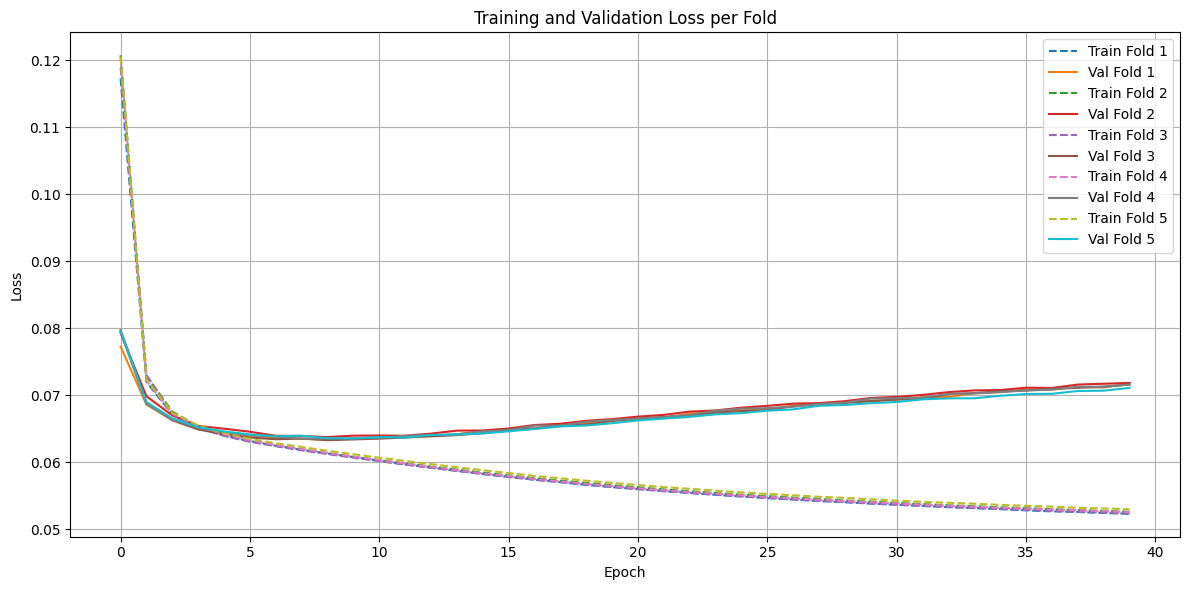

In [26]:
# Plotting after training
plt.figure(figsize=(12, 6))
for fold in range(k_folds):
    plt.plot(all_train_losses[fold], label=f'Train Fold {fold+1}', linestyle='--')
    plt.plot(all_val_losses[fold], label=f'Val Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Load best model
best_model = SimpleMLP(input_dim=X.shape[1], output_dim=y_train_tensor.shape[1])
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [28]:
import torch
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision

device = next(model.parameters()).device  # get device
idx_to_item_id = {v: k for k, v in item_id_to_idx.items()}

model.eval()
with torch.no_grad():
    # Move tensors to device
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

    # Top-6 predictions per sample
    _, top6_indices = torch.topk(outputs, k=6, dim=1)

    total_samples = y_test_tensor.size(0)
    all_slots_correct_samples = 0
    single_slot_correct_samples = 0

    all_recommendations = []  # <-- list to hold recommended item IDs per sample

    for i in range(total_samples):
        true_indices = (y_test_tensor[i] == 1).nonzero(as_tuple=True)[0]

        # Skip samples without true labels (optional)
        if true_indices.numel() == 0:
            all_recommendations.append([])  # empty recommendation
            continue

        predicted_top6 = top6_indices[i]

        # Build recommendation list of actual item IDs
        recommended_items = [idx_to_item_id[idx.item()] for idx in predicted_top6]
        all_recommendations.append(recommended_items)

        if set(true_indices.tolist()).issubset(set(predicted_top6.tolist())):
            all_slots_correct_samples += 1
            single_slot_correct_samples += 1
        else:
            correct_in_top6 = sum(idx in set(predicted_top6.tolist()) for idx in true_indices.tolist())
            single_slot_correct_samples += correct_in_top6 / len(true_indices)

    all_slots_accuracy = all_slots_correct_samples / total_samples
    single_slot_accuracy = single_slot_correct_samples / total_samples

    print(f"All slots - accuracy: {all_slots_accuracy:.4f}")
    print(f"Single slot - accuracy: {single_slot_accuracy:.4f}")

    # Torchmetrics recall and precision @6
    num_labels = y_test_tensor.size(1)
    recall_metric = MultilabelRecall(num_labels=num_labels, average='macro').to(device)
    precision_metric = MultilabelPrecision(num_labels=num_labels, average='macro').to(device)

    preds_topk = torch.zeros_like(outputs)
    preds_topk.scatter_(1, top6_indices, 1)

    recall_at_6 = recall_metric(preds_topk.int(), y_test_tensor.int())
    precision_at_6 = precision_metric(preds_topk.int(), y_test_tensor.int())

    print(f"Recall@6: {recall_at_6.item():.4f}")
    print(f"Precision@6: {precision_at_6.item():.4f}")

# You now have all_recommendations as a list of length total_samples,
# where each element is a list of the 6 recommended item IDs for that sample.


Test Loss: 0.0711
All slots - accuracy: 0.2977
Single slot - accuracy: 0.6730
Recall@6: 0.5246
Precision@6: 0.3364


In [29]:
def show_build(item_ids):
    fig, axs = plt.subplots(1, len(item_ids), figsize=(2 * len(item_ids), 2))
    if len(item_ids) == 1:
        axs = [axs]  # ensure iterable
    for i, id in enumerate(item_ids):
        icon = get_item_icon(id)
        if icon:
            axs[i].imshow(icon)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def compare_builds(
        df: pd.DataFrame,
        all_recommendations: list,
        build_df,
        original_index,
        idx: int):
    orig_idx = original_index[idx]

    allies = []
    enemies = []
    analysed_champion = ""
    for col in df.columns:
        if df.loc[orig_idx, col] == 0:
            continue
        if col.startswith("player"):
            analysed_champion = col.split("_")[1]
            print(f"Champion: {analysed_champion}")
        elif col.startswith("ally"):
            allies.append(col.split("_")[1])
        elif col.startswith("enemy"):
            enemies.append(col.split("_")[1])
        elif col in LANES:
            print(f"Lane: {col.lower().capitalize()}")

    reccomended_items = sorted(all_recommendations[idx], key=lambda x: x if x > 0 else 9999)
    print(f"Allies: {', '.join(champ for champ in allies)}")
    print(f"Enemies: {', '.join(champ for champ in enemies)}")
    print(f"Recommendations: {', '.join(
        [f"{get_item_name(item):<30}" for item in reccomended_items]
    )}")

    original_build = []
    for i in range(6):
        item_col = f"items_{i}"
        item_id = build_df.loc[orig_idx, item_col]
        if item_id.is_integer():
            original_build.append(int(item_id))
    original_build.sort(key=lambda x: x if x > 0 else 9999)
    print(f"Original IDX: {orig_idx}")
    print(f"Original build : {', '.join(
        [f'{get_item_name(item):<30}' for item in original_build]
    )}")

    print("Recommended build")
    show_build(sorted(reccomended_items))

    print("Original build")
    show_build(sorted(original_build, key=lambda x: x if x > 0 else 9999))

In [30]:
# selected_champion = X_custom["championId"].value_counts().idxmax()
selected_champion = "Akshan"
selected_champion_id = get_champion_id(selected_champion)
print(f"Selected champion: {get_champion_name(selected_champion)} - ID: {selected_champion_id}")

Selected champion: None - ID: 166


In [31]:
df_selected = X_test.iloc[:len(all_recommendations), :]
df_selected.loc[:, "index"] = range(len(df_selected))
df_selected = df_selected[df_selected[f"player_{selected_champion}"] == 1]

C:\Users\User\AppData\Local\Temp\ipykernel_5412\3797275107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, "index"] = range(len(df_selected))


Lane: Middle
Champion: Akshan
Allies: Kaisa, Zed, Mordekaiser, Elise
Enemies: Mel, Sett, Lucian, Shaco, Fiddlesticks
Recommendations: Boots of Swiftness            , Lord Dominik's Regards        , Statikk Shiv                  , Rapid Firecannon              , Mercury's Treads              , The Collector                 
Original IDX: 2434
Original build : Statikk Shiv                  , Rapid Firecannon              , Swiftmarch                    , The Collector                 ,                               ,                               
Recommended build


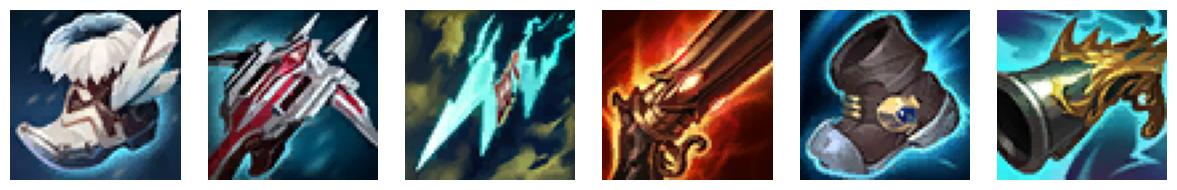

Original build


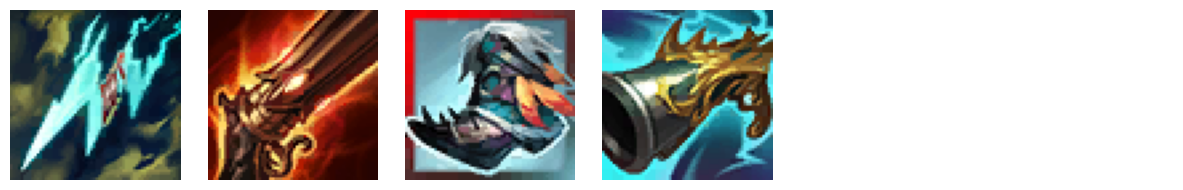

Lane: Middle
Champion: Akshan
Allies: Thresh, XinZhao, Heimerdinger, Kalista
Enemies: Kaisa, Zyra, Pyke, Aatrox, Zed
Recommendations: Boots of Swiftness            , Mortal Reminder               , Statikk Shiv                  , Blade of the Ruined King      , Kraken Slayer                 , The Collector                 
Original IDX: 184184
Original build : Plated Steelcaps              , Statikk Shiv                  , The Collector                 ,                               ,                               ,                               
Recommended build


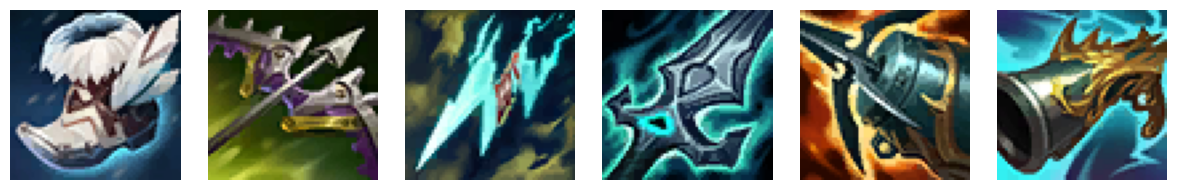

Original build


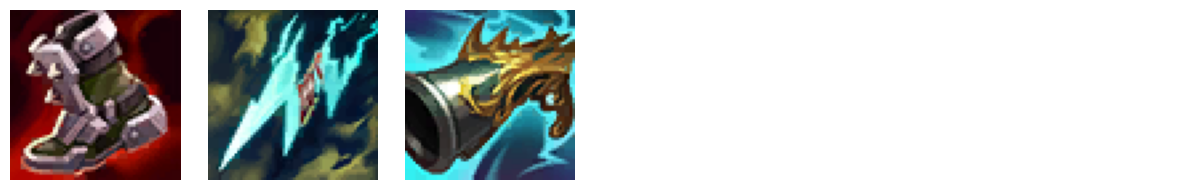

Lane: Middle
Champion: Akshan
Allies: Sivir, Kayle, Karthus, Pyke
Enemies: Jhin, Ryze, Zilean, Aurora, Kayn
Recommendations: Boots of Swiftness            , Lord Dominik's Regards        , Statikk Shiv                  , Youmuu's Ghostblade           , Swiftmarch                    , The Collector                 
Original IDX: 191875
Original build : Statikk Shiv                  , Rapid Firecannon              , Mercury's Treads              , The Collector                 ,                               ,                               
Recommended build


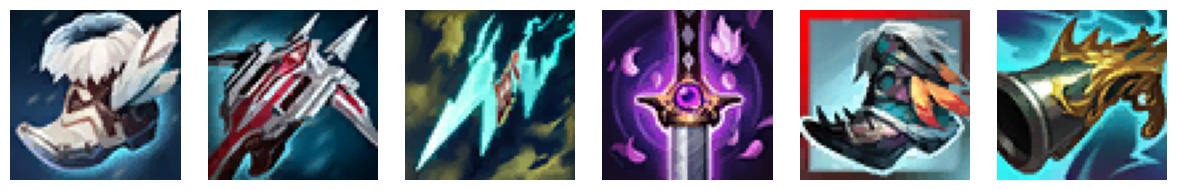

Original build


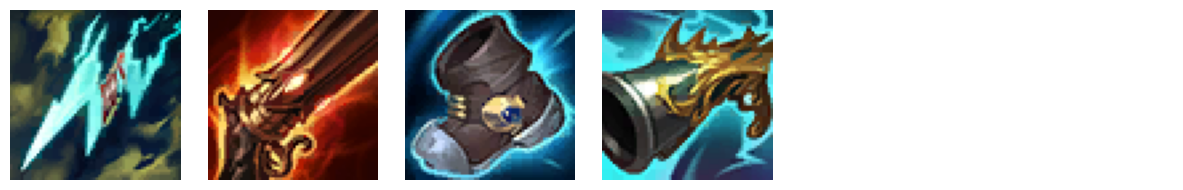

Lane: Middle
Champion: Akshan
Allies: Viktor, Sion, Briar, Elise
Enemies: Katarina, Lulu, Karthus, Twitch, KSante
Recommendations: Boots of Swiftness            , Yun Tal Wildarrows            , Lord Dominik's Regards        , Statikk Shiv                  , Mercury's Treads              , The Collector                 
Original IDX: 39804
Original build : Lord Dominik's Regards        , Statikk Shiv                  , Swiftmarch                    ,                               ,                               ,                               
Recommended build


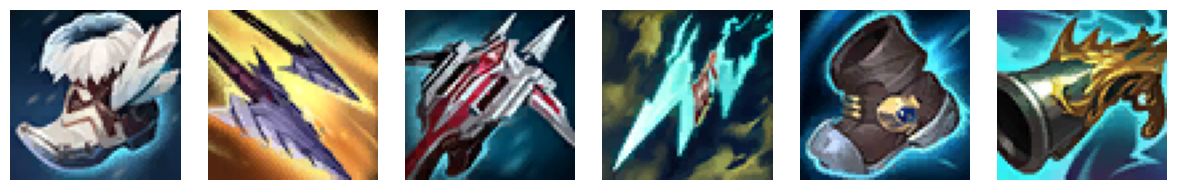

Original build


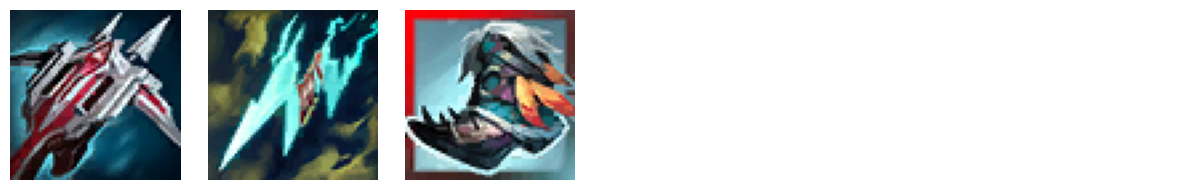

Lane: Middle
Champion: Akshan
Allies: Janna, Twitch, Shen, Lillia
Enemies: Zilean, Mel, Hecarim, Jax, Ekko
Recommendations: Boots of Swiftness            , Lord Dominik's Regards        , Statikk Shiv                  , Mercury's Treads              , Swiftmarch                    , The Collector                 
Original IDX: 191954
Original build : Boots of Swiftness            , Statikk Shiv                  , The Collector                 ,                               ,                               ,                               
Recommended build


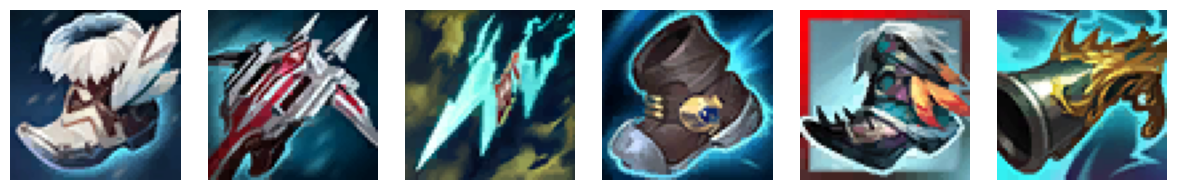

Original build


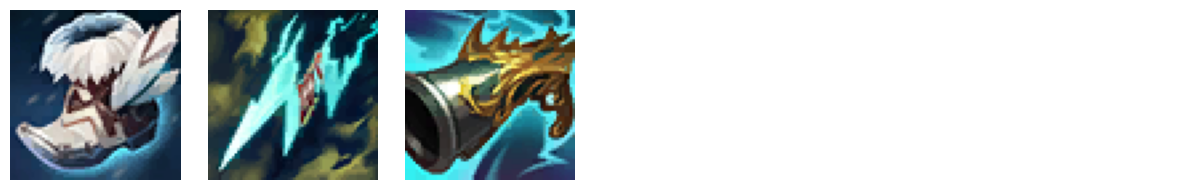

Lane: Top
Champion: Akshan
Allies: Diana, Thresh, Ekko, MissFortune
Enemies: Ezreal, Bard, Syndra, KSante, Kayn
Recommendations: Berserker's Greaves           , Boots of Swiftness            , Lord Dominik's Regards        , Plated Steelcaps              , Statikk Shiv                  , The Collector                 
Original IDX: 38451
Original build : Boots of Swiftness            , Black Cleaver                 ,                               ,                               ,                               ,                               
Recommended build


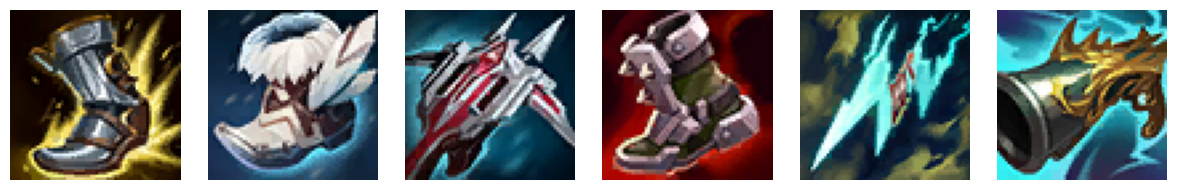

Original build


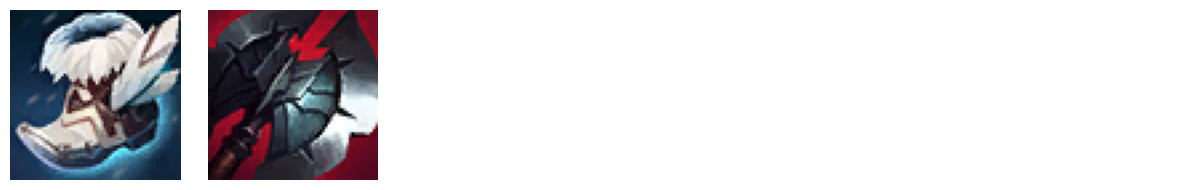

Lane: Middle
Champion: Akshan
Allies: Kaisa, Renekton, Malphite, Shaco
Enemies: Naafiri, Poppy, Jinx, Ahri, Heimerdinger
Recommendations: Boots of Swiftness            , Yun Tal Wildarrows            , Statikk Shiv                  , Rapid Firecannon              , Navori Flickerblade           , The Collector                 
Original IDX: 140334
Original build : Boots of Swiftness            , Lord Dominik's Regards        , Statikk Shiv                  , Rapid Firecannon              , The Collector                 ,                               
Recommended build


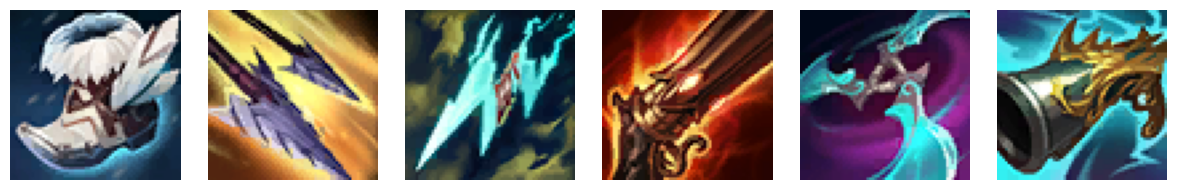

Original build


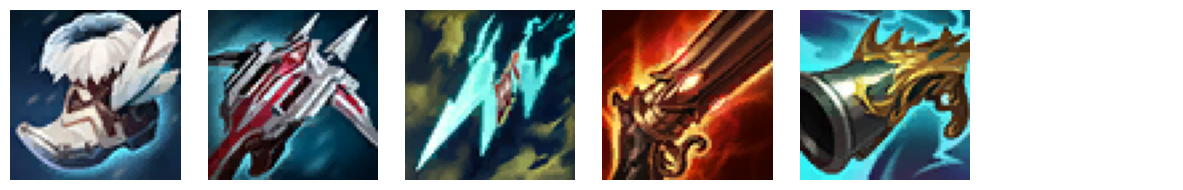

Lane: Middle
Champion: Akshan
Allies: Nasus, Samira, Lux, Kindred
Enemies: Kaisa, Brand, Aatrox, Shaco, Talon
Recommendations: Berserker's Greaves           , Lord Dominik's Regards        , Statikk Shiv                  , Blade of the Ruined King      , Kraken Slayer                 , The Collector                 
Original IDX: 88624
Original build : Plated Steelcaps              , Rapid Firecannon              , Youmuu's Ghostblade           , The Collector                 ,                               ,                               
Recommended build


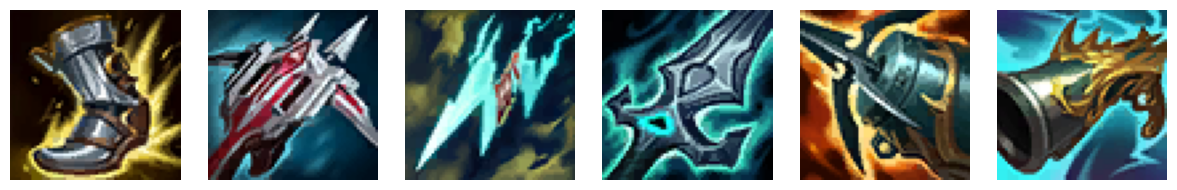

Original build


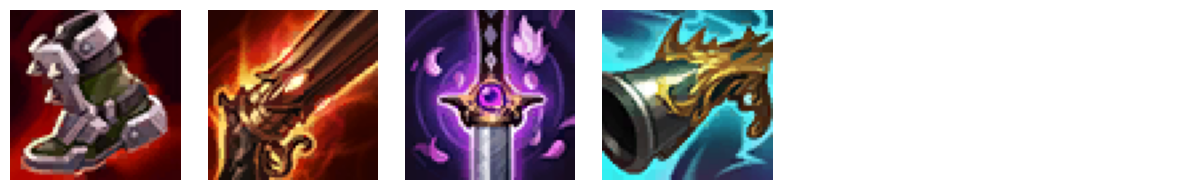

Lane: Middle
Champion: Akshan
Allies: Sivir, Rengar, Braum, Gragas
Enemies: Karma, Aatrox, Ezreal, Veigar, RekSai
Recommendations: Berserker's Greaves           , Boots of Swiftness            , Lord Dominik's Regards        , Statikk Shiv                  , Kraken Slayer                 , The Collector                 
Original IDX: 137884
Original build : Boots of Swiftness            , Statikk Shiv                  , The Collector                 ,                               ,                               ,                               
Recommended build


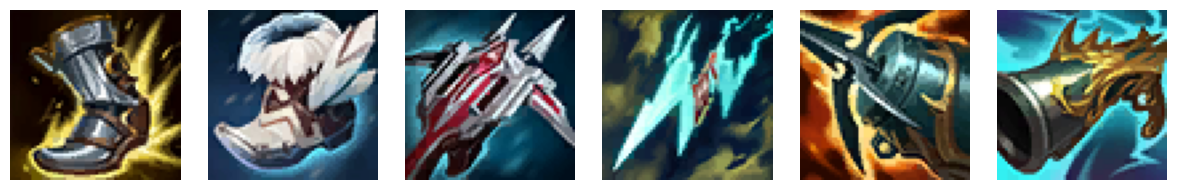

Original build


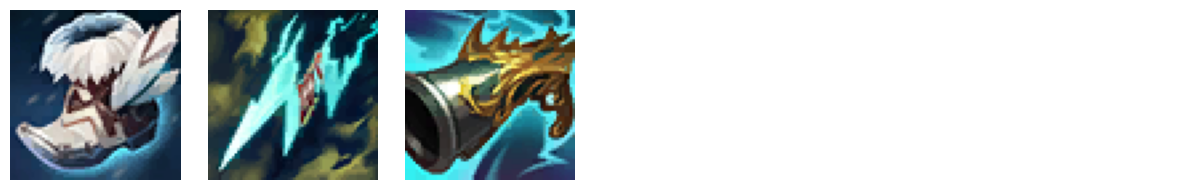

Lane: Middle
Champion: Akshan
Allies: Karma, Ezreal, Nocturne, Darius
Enemies: Kaisa, Zed, Rakan, Kled, Tryndamere
Recommendations: Boots of Swiftness            , Lord Dominik's Regards        , Plated Steelcaps              , Statikk Shiv                  , Kraken Slayer                 , The Collector                 
Original IDX: 63834
Original build : Statikk Shiv                  , Armored Advance               ,                               ,                               ,                               ,                               
Recommended build


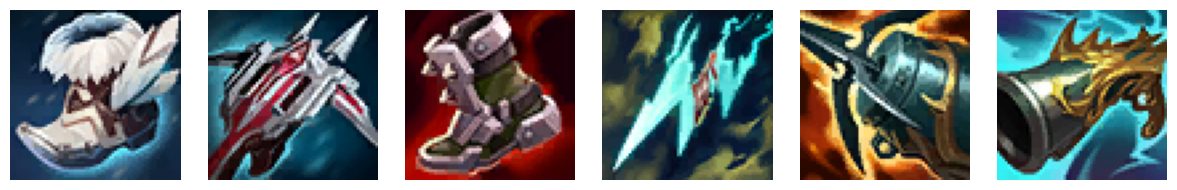

Original build


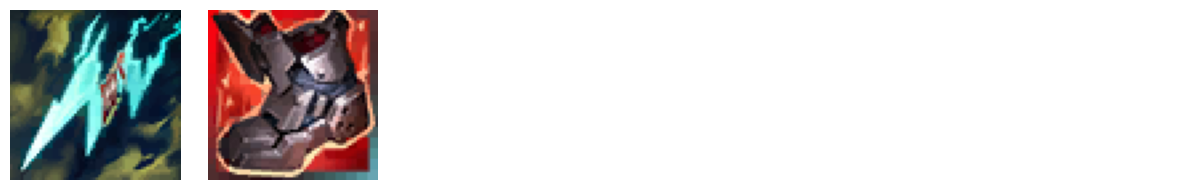

In [32]:
for index, row in list(df_selected.iterrows())[:10]:
    idx = int(row["index"])
    compare_builds(
        X_test,
        all_recommendations,
        y_test,
        pd.Series(
            {
                idx_from_0:
                    X_test.index[idx_from_0]
                for idx_from_0 in range(len(X_test))
            }
        ),
        idx
    )

In [33]:
# Save
torch.save(model.state_dict(), "model_weights.pth")

# Load (later)
model = SimpleMLP()
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # Set to eval mode if you're evaluating/inference

TypeError: SimpleMLP.__init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'